# Women's E-Commerce Clothing Reviews

- [x] Выполнить предобработку корпуса текста отзывов e-com площадки (колонка Review Text в файле в приложении) используя любые пройденные методы очистки данных.  
- [x] С помощью любой из представленных на hugginface hub реализуйте конвейер (до)обучения трансформерной NLP-модели  для задачи бинарной классификации показателя  Recommended IND (рекомендует ли клиент продукт или нет).
Проведите валидацию с помощью f1 на отложенной выборке.  
- [x] Дополнительное (бонусное) задание: реализовать аналогичный п.2 конвейер для рейтинга (колонка Rating) на несбалансированном датасете.


Решение в формате ссылки на Google Colaboratory необходимо выложить в соответствующее задание на учебном портале.

Дедлайн сдачи: **25 февраля 23:59**


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# Скачиваем датасет с диска

In [ ]:
!wget 'https://nextcloud.fintechhub.ru/index.php/s/TFcDB7dDZmQE2bt/download?path=%2F%D0%94%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%94%D0%97%E2%84%961%20%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F&files=Womens%20Clothing%20E-Commerce%20Reviews.csv.zip' -O Womens_Clothing_Commerce_Reviews.csv.zip
!unzip Womens_Clothing_Commerce_Reviews.csv.zip
!pip install -qq transformers datasets

--2024-02-25 14:55:37--  https://nextcloud.fintechhub.ru/index.php/s/TFcDB7dDZmQE2bt/download?path=%2F%D0%94%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%94%D0%97%E2%84%961%20%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F&files=Womens%20Clothing%20E-Commerce%20Reviews.csv.zip
Resolving nextcloud.fintechhub.ru (nextcloud.fintechhub.ru)... 85.172.14.211
Connecting to nextcloud.fintechhub.ru (nextcloud.fintechhub.ru)|85.172.14.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2924120 (2.8M) [application/zip]
Saving to: ‘Womens_Clothing_Commerce_Reviews.csv.zip’

Womens_Clothing_Com 100%[===================>]   2.79M  5.36MB/s    in 0.5s    

2024-02-25 14:55:38 (5.36 MB/s) - ‘Womens_Clothing_Commerce_Reviews.csv.zip’ saved [2924120/2924120]

Archive:  Womens_Clothing_Commerce_Reviews.csv.zip
  inflating: Womens Clothing E-Commerce Reviews.csv  


# Clearml

In [ ]:
# Не скачивать
# !pip install clearml

  Obtaining dependency information for clearml from https://files.pythonhosted.org/packages/6e/58/cc153586b5a68646e57887da5763b794e85eea34545c6bf9a2be2b702666/clearml-1.14.4-py2.py3-none-any.whl.metadata
  Obtaining dependency information for furl>=2.0.0 from https://files.pythonhosted.org/packages/41/ef/a572e03144d18842c480bd25165ec50ddc20b1744b2aeaaae4408a281f6f/furl-2.1.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pathlib2>=2.3.0 from https://files.pythonhosted.org/packages/09/eb/4af4bcd5b8731366b676192675221c5324394a580dfae469d498313b5c4a/pathlib2-2.3.7.post1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pyjwt<2.9.0,>=2.4.0 from https://files.pythonhosted.org/packages/2b/4f/e04a8067c7c96c364cef7ef73906504e2f40d690811c021e1a1901473a19/PyJWT-2.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for referencing<0.40 from https://files.pythonhosted.org/packages/90/10/1c92edb0a0a14b67ff825bc338e74bc49ab27d3f3bae3f9a02838cba54

In [ ]:
class InitClearml:
    def __init__(self, project_name: str, task_name: str):
        self.project_name = project_name
        self.task_name  = task_name

    def init_task(self):
        self.clearml_available = False
        try:
            from clearml import Task

            web_server = "https://app.clear.ml"  # @param {type:"string"}
            api_server = "https://api.clear.ml"  # @param {type:"string"}
            files_server = "https://files.clear.ml"  # @param {type:"string"}
            access_key = ""  # @param {type:"string"}
            secret_key = ""  # @param {type:"string"}

            if access_key == "" or secret_key == "":
                raise Exception("Empty access_key or secret_key")

            Task.set_credentials(
                web_host=web_server,
                api_host=api_server,
                files_host=files_server,
                key=access_key,
                secret=secret_key,
            )

            self.clearml_available = True
            return Task

        except ImportError:
            return
        except Exception as e:
            print(e)

    def init_experiment(self, Task):
        if self.clearml_available:
            task = Task.init(project_name=self.project_name, task_name=self.task_name)
            return task

In [ ]:
! pip install -U accelerate
! pip install -U transformers

# Импорт библиотек

In [ ]:
import re

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn as nn
from datasets import DatasetDict, load_dataset, load_metric
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AdamW,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    get_scheduler,
)

sns.set(font_scale=1.2)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
english_stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Основная часть

In [ ]:
df_reviews = pd.read_csv(
    "Womens Clothing E-Commerce Reviews.csv", delimiter=",", index_col=0
)
df_reviews.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


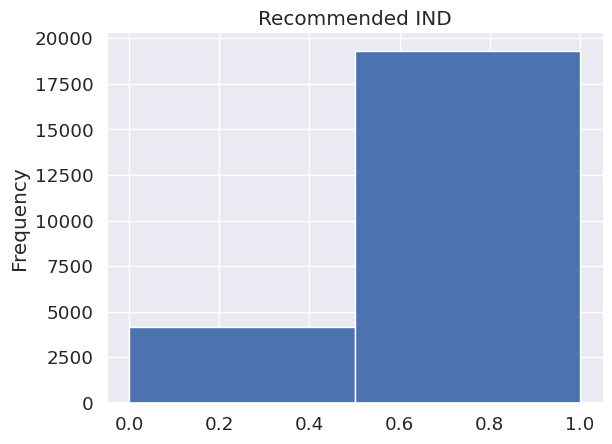

In [ ]:
# @title Recommended IND
df_reviews["Recommended IND"].plot(kind="hist", bins=2, title="Recommended IND")
plt.gca().spines[
    [
        "top",
        "right",
    ]
].set_visible(False)

In [ ]:
df_reviews_binary_classification = df_reviews[["Review Text", "Recommended IND"]]

In [ ]:
df_reviews_binary_classification.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review Text      22641 non-null  object
 1   Recommended IND  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 550.5+ KB


In [ ]:
for i in df_reviews_binary_classification.sample(5).iterrows():
    print(f"{i[1]['Recommended IND']}: {i[1]['Review Text']}", end="\n\n")

1: Tracy reese always pleases. this coat is absolutely awesome. it is gorgeous! the faux fur is soft and cozy. this coat is warm. i love the snap closure. this is the sort of attire that makes you feel lovely and is cheerful for those dull winter days. so happy to have in my wardrobe. a collector's item, for sure.

1: I was worried this skirt might look too much like a bedspread. but it is so gorgeous on and the cut is so flattering. i ordered a petite small and it fits perfectly. great fall/winter skirt.

1: The first reviewer summed up many of my thoughts exactly. i don't like to go without a bra and this dress with its slightly wider, almost cap-sleeve straps solves my problem perfectly. i love this neckline and wish i'd see it in more maxi dresses! the crossover and cutouts in the back mimic the lines of a traditional indian sari blouse and skirt, again without sacrificing bra coverage. just a beautiful and inspired design - definitely a standout in the sea of summer maxi dresses i

## Препроцессинг текста

In [ ]:
tokenizer_and_lemmatizer = spacy.load("en_core_web_sm")
lemmatizer = WordNetLemmatizer()

delete_punct_no_split_word = re.compile(r"[^\w\s\']")
delete_body_weight = re.compile(r"\b\d+\s*lbs\b")
delete_height = re.compile(r"\b\d+\'\s*\d+\"?\b")
delete_clothing_sizes_numeric = re.compile(r"\b\d+-\d+\b|\b\d+,\d+\b")

# Добавим сохранение размеров при лемматизации
clothing_sizes = ["xxs", "xs", "s", "m", "l", "xl", "xxl"]


def preprocess_text(text: str, method: str = "nltk", clean_stopwords: bool = False):
    text = str(text).lower()

    text = delete_body_weight.sub("", text)
    text = delete_height.sub("", text)
    text = delete_clothing_sizes_numeric.sub("", text)
    text = delete_punct_no_split_word.sub("", text)

    if method == "spacy":
        normalized_tokens = [token.lemma_ for token in tokenizer_and_lemmatizer(text)]
    elif method == "nltk":
        tokens = word_tokenize(text)
        normalized_tokens = [
            lemmatizer.lemmatize(token) if token not in clothing_sizes else token
            for token in tokens
        ]

    if clean_stopwords:
        normalized_tokens = [
            token for token in normalized_tokens if token not in english_stopwords
        ]

    return " ".join(normalized_tokens)

In [ ]:
for i in np.random.randint(0, len(df_reviews_binary_classification), 5):
    print("Ориг:", df_reviews_binary_classification["Review Text"][i])
    print(
        "Чист:",
        preprocess_text(
            df_reviews_binary_classification["Review Text"][i], method="spacy"
        ),
        "\n",
    )

Ориг: I love this dress! good for work or social occasions. flowy fabric, and not boxy. the length is perfect, not too short.  i can't wait to wear it. picture is accurate as to color.
Чист: I love this dress good for work or social occasion flowy fabric and not boxy the length be perfect not too short   I can not wait to wear it picture be accurate as to color 

Ориг: I love dolan dresses! the fabrics are always beautiful, and the colors are always unique. i usually wear an xs petite in dolan, but i ordered both the xs and the xs petite, and i think i'm going to keep the xs. i had a hard time deciding which to keep, but the xs petite was just a hair too short. i think this is a versatile dress for all seasons. you could pair it with tights in fall/winter, but it is great for spring/summer, too...
Чист: I love dolan dress the fabric be always beautiful and the color be always unique I usually wear an xs petite in dolan but I order both the xs and the xs petite and I think I be go to ke

In [ ]:
df_cleared = df_reviews_binary_classification.copy()
df_cleared["Review Text"] = df_cleared["Review Text"].apply(
    lambda x: preprocess_text(x, method="spacy", clean_stopwords=False)
)

In [ ]:
df_cleared.head()

,Review Text,Recommended IND
0,absolutely wonderful silky and sexy and comf...,1
1,love this dress it be sooo pretty I happen...,1
2,I have such high hope for this dress and reall...,0
3,I love love love this jumpsuit it be fun flirt...,1
4,this shirt be very flattering to all due to th...,1


In [ ]:
df_cleared.to_csv("df_cleared.csv", index=False)

# Модель и обучение

In [ ]:
clearml_logging = InitClearml("FinTech VTB", "distilbert/distilbert-base-uncased-finetuned-sst-2-english_weight_class")
Task = clearml_logging.init_task()
task = clearml_logging.init_experiment(Task)
clearml_available = clearml_logging.clearml_available

ClearML Task: created new task id=4b2c1210fcbd42549ca5f905d71bb301
2024-02-25 17:22:07,917 - clearml.Repository Detection - WARNING - Password protected Jupyter Notebook server was found! Add `sdk.development.jupyter_server_password=<jupyter_password>` to ~/clearml.conf
2024-02-25 17:22:07,921 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/a0e39586066d49ac87ba40b5f2c1ec16/experiments/4b2c1210fcbd42549ca5f905d71bb301/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


## Инициализация модели

In [ ]:
task_params = {}
model_params = {}

model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
model_params["model_name"] = model_name

tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model_params["tokenizer"] = str(tokenizer.__class__)

num_labels = 2
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model_params["model"] = str(model.__class__)
model_params["num_class"] = num_labels

task_params["model"] = model_params

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Очищенный датасет

Чистим пустые ячейки в датасете

In [ ]:
full_dataset = load_dataset("csv", data_files="df_cleared.csv")
full_dataset = full_dataset.rename_columns(
    column_mapping={"Recommended IND": "labels", "Review Text": "text"}
)
# Фильтрация записей, в которых текстовые поля или метки не являются None
full_dataset = full_dataset.filter(
    lambda example: example["text"] is not None and example["labels"] is not None
)

full_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 22641
    })
})

In [ ]:
tokenizer.tokenize(full_dataset["train"][0]["text"])

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable']

## Train/Validate/Test

In [ ]:
train_valid_test = (
    full_dataset["train"]
    .class_encode_column("labels")
    .train_test_split(test_size=0.4, stratify_by_column="labels", seed=1)
)
valid_test = train_valid_test["test"].train_test_split(
    test_size=0.5, stratify_by_column="labels", seed=1
)

dataset = DatasetDict(
    {
        "train": train_valid_test["train"],
        "validate": valid_test["train"],
        "test": valid_test["test"],
    }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 13584
    })
    validate: Dataset({
        features: ['text', 'labels'],
        num_rows: 4528
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 4529
    })
})

In [ ]:
np.unique(dataset["test"]["labels"], return_counts=True)

(array([0, 1]), array([ 821, 3708]))

In [ ]:
weight_classes_binary = compute_class_weight(class_weight="balanced", classes=sorted(list(set(full_dataset["train"]["labels"]))), y=full_dataset["train"]["labels"]).tolist()
weight_classes_binary[0] -= 1
weight_classes_binary

NameError: name 'compute_class_weight' is not defined

In [ ]:
task_params["weight_classes_binary"] = weight_classes_binary

## Токенизация

In [ ]:
dataset_info = dataset.map(
    lambda e: tokenizer(e["text"], truncation=True), batched=True
)

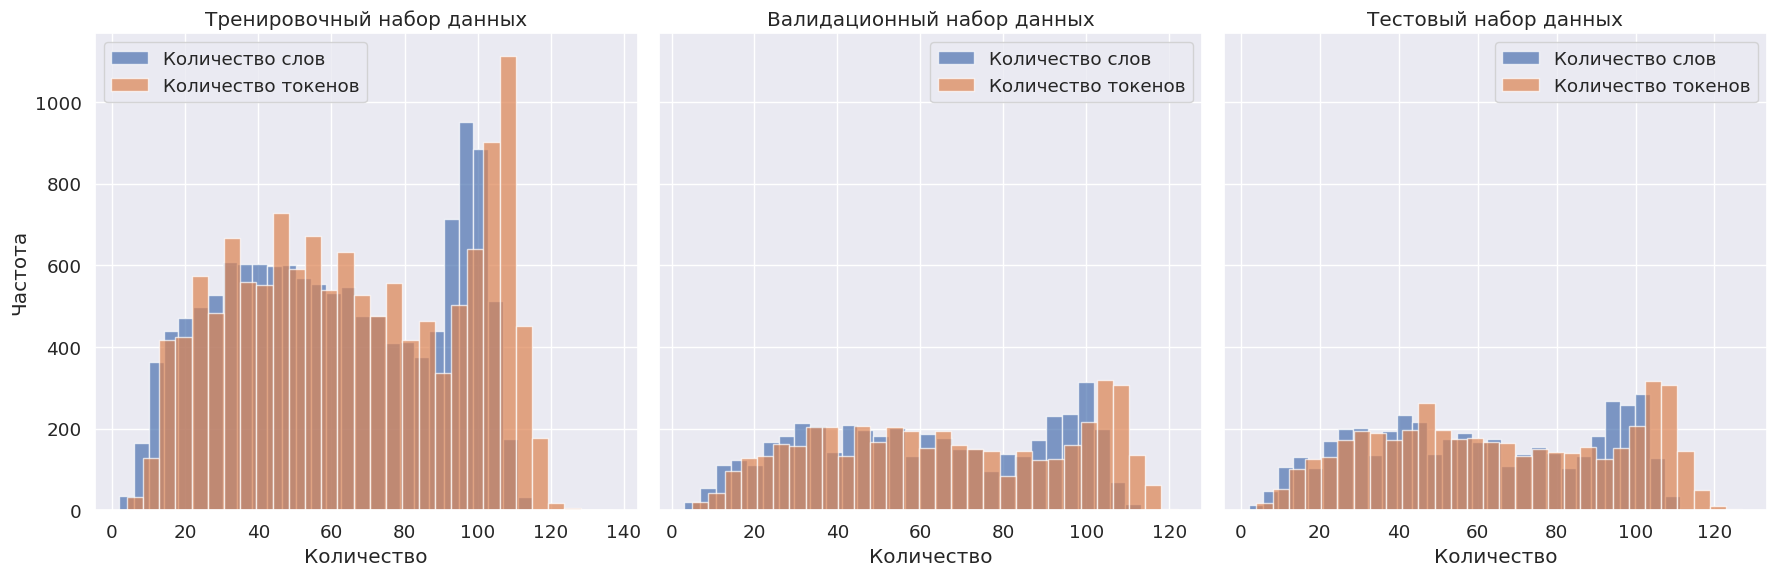

In [ ]:
train_word_counts = [len(example["text"].split()) for example in dataset["train"]]
train_token_counts = [len(example) for example in dataset_info["train"]["input_ids"]]

valid_word_counts = [len(example["text"].split()) for example in dataset["validate"]]
valid_token_counts = [len(example) for example in dataset_info["validate"]["input_ids"]]

test_word_counts = [len(example["text"].split()) for example in dataset["test"]]
test_token_counts = [len(example) for example in dataset_info["test"]["input_ids"]]

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].hist(train_word_counts, bins=30, alpha=0.7, label="Количество слов")
axes[0].hist(train_token_counts, bins=30, alpha=0.7, label="Количество токенов")
axes[0].set_title("Тренировочный набор данных")
axes[0].set_xlabel("Количество")
axes[0].set_ylabel("Частота")
axes[0].legend()

axes[1].hist(valid_word_counts, bins=30, alpha=0.7, label="Количество слов")
axes[1].hist(valid_token_counts, bins=30, alpha=0.7, label="Количество токенов")
axes[1].set_title("Валидационный набор данных")
axes[1].set_xlabel("Количество")
axes[1].legend()

axes[2].hist(test_word_counts, bins=30, alpha=0.7, label="Количество слов")
axes[2].hist(test_token_counts, bins=30, alpha=0.7, label="Количество токенов")
axes[2].set_title("Тестовый набор данных")
axes[2].set_xlabel("Количество")
axes[2].legend()


plt.tight_layout()
plt.show()

In [ ]:
params_tokenizer = {}
params_tokenizer["max_length_seq_words"] = 125

dataset = dataset.map(
    lambda e: tokenizer(
        e["text"],
        truncation=True,
        max_length=params_tokenizer["max_length_seq_words"],
        padding="max_length",
    ),
    batched=True,
)

task_params["tokenizer"] = params_tokenizer

In [ ]:
len(dataset["train"]["input_ids"][500])

125

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 13584
    })
    validate: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 4528
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 4529
    })
})

## Dataloader

In [ ]:
params_datasets = {}
params_datasets["batch_size_train"] = 32
params_datasets["batch_size_validate"] = 16
params_datasets["batch_size_test"] = 16

dataset_delete_text = dataset.remove_columns("text")
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset_delete_text.set_format(type="torch", device=device)
train_dataloader = DataLoader(
    dataset_delete_text["train"],
    shuffle=True,
    batch_size=params_datasets["batch_size_train"],
)
validate_dataloader = DataLoader(
    dataset_delete_text["validate"],
    shuffle=True,
    batch_size=params_datasets["batch_size_validate"],
)
test_dataloader = DataLoader(
    dataset_delete_text["test"],
    shuffle=False,
    batch_size=params_datasets["batch_size_test"],
)

task_params["params_dataset"] = params_datasets

## Настройки для обучения

In [ ]:
optimizer_params = {}

optimizer_params["lr"] = 3e-04
optimizer_params["betas"] = (0.9, 0.999)
optimizer_params["epsilon"] = 1e-08
optimizer_params["weight_decay"] = 0.00
task_params["epochs"] = 3

optimizer = AdamW(
    model.parameters(),
    lr=optimizer_params["lr"],
    betas=optimizer_params["betas"],
    eps=optimizer_params["epsilon"],
    weight_decay=optimizer_params["weight_decay"],
)
num_training_steps = task_params["epochs"] * len(train_dataloader)

class_weights = torch.tensor(weight_classes_binary).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=400,
    num_training_steps=num_training_steps,
)

task_params["optimizer_params"] = optimizer_params
if clearml_available:
    task.connect(task_params)

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



## Функции обучения и валидации

In [ ]:
def train(model, train_loader, criterion, optimizer, lr_sheduler):
    model.train()

    running_loss = []
    pbar = tqdm(train_loader, total=len(train_loader), desc="Training")
    for i, batch in enumerate(pbar, start=1):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = criterion(outputs.logits, batch["labels"])

        # Loss в clearml
        if clearml_available:
            task.logger.report_scalar(
                title="Loss Train",
                series="Loss",
                value=loss.item(),
                iteration=(epoch - 1) * len(train_loader) + i,
            )

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        running_loss.append(loss.item())

        pbar.set_postfix({"running_loss": np.mean(running_loss[-25:])})

    return np.mean(running_loss)


def validate(
    model,
    val_loader,
    criterion,
    is_return_labels_true_and_predict=False,
    title_name="Validation",
    type_metric: str = "macro"
) -> dict[np.ndarray] | None:
    """
    Parameters
    -----------
    is_return_labels_true_and_predict: bool
        Возврат актуальных и предсказанных меток
    """
    model.eval()
    labels = {"y_true": [], "y_pred": []}
    running_loss = []

    pbar = tqdm(val_loader, total=len(val_loader), desc=title_name)
    with torch.no_grad():
        f1 = load_metric("f1", trust_remote_code=True)
        acc = load_metric("accuracy", trust_remote_code=True)
        precision = load_metric("precision", trust_remote_code=True)
        recall = load_metric("recall", trust_remote_code=True)

        for i, batch in enumerate(pbar, start=1):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = criterion(outputs.logits, batch["labels"])

            # Loss в clearml
            if clearml_available:
                task.logger.report_scalar(
                    title=f"Loss {title_name}",
                    series="Loss",
                    value=loss.item(),
                    iteration=(epoch - 1) * len(val_loader) + i,
                )

            running_loss.append(loss.item())

            logits = outputs.logits.detach().cpu()
            predictions = torch.argmax(logits, dim=-1)
            ref = batch["labels"].detach().cpu()

            labels["y_true"] = np.concatenate((labels["y_true"], ref.numpy()))
            labels["y_pred"] = np.concatenate((labels["y_pred"], predictions.numpy()))

            f1.add_batch(predictions=predictions, references=ref)
            acc.add_batch(predictions=predictions, references=ref)
            precision.add_batch(predictions=predictions, references=ref)
            recall.add_batch(predictions=predictions, references=ref)

            pbar.set_postfix({"running_loss": np.mean(running_loss[-25:])})

        test_acc = acc.compute()["accuracy"]
        test_precision = precision.compute(average=type_metric)["precision"]
        test_recall = recall.compute(average=type_metric)["recall"]
        f1 = f1.compute(average=type_metric)["f1"]
        print(f"[{epoch}] {title_name} Accuracy: {test_acc:.4f}")
        print(f"[{epoch}] {title_name} Precision: {test_precision:.4f}")
        print(f"[{epoch}] {title_name} Recall: {test_recall:.4f}")
        print(f"[{epoch}] {title_name} F1: {f1:.4f}")

        if clearml_available:
            task.logger.report_scalar(
                title=f"Metrics {title_name}",
                series="Accuracy",
                value=test_acc,
                iteration=epoch,
            )
            task.logger.report_scalar(
                title=f"Metrics {title_name}",
                series=f"Precision ({type_metric})",
                value=test_precision,
                iteration=epoch,
            )
            task.logger.report_scalar(
                title=f"Metrics {title_name}",
                series=f"Recall ({type_metric})",
                value=test_recall,
                iteration=epoch,
            )
            task.logger.report_scalar(
                title=f"Metrics {title_name}",
                series=f"F1 ({type_metric})",
                value=f1,
                iteration=epoch,
            )

        if is_return_labels_true_and_predict:
            return labels, f1

        return f1

### Обучение

In [ ]:
best_f1 = 0.0
for epoch in range(1, task_params["epochs"] + 1):
    print(f"Epoch: {epoch}")

    loss_train = train(model, train_dataloader, criterion, optimizer, lr_scheduler)
    f1 = validate(model, validate_dataloader, criterion, type_metric="binary")

    if f1 > best_f1:
        best_f1 = f1
        model.save_pretrained(
            f"best_{task_params['model']['model_name']}_max={best_f1}_len=100"
        )
        print(f"New best F1: {best_f1}. Model saved.")

Epoch: 1


Validation:   0%|          | 0/283 [00:00<?, ?it/s]/tmp/ipykernel_2522/3853733287.py:53: FutureWarning:

load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate

Validation: 100%|██████████| 283/283 [00:20<00:00, 13.85it/s, running_loss=0.345]


[1] Validation Accuracy: 0.7716
[1] Validation Precision: 0.9897
[1] Validation Recall: 0.7287
[1] Validation F1: 0.8394
New best F1: 0.8393911152531842. Model saved.
Epoch: 2


Validation: 100%|██████████| 283/283 [00:19<00:00, 14.29it/s, running_loss=0.323]


[2] Validation Accuracy: 0.8982
[2] Validation Precision: 0.9559
[2] Validation Recall: 0.9180
[2] Validation F1: 0.9366
New best F1: 0.93657999724859. Model saved.
Epoch: 3


Validation: 100%|██████████| 283/283 [00:20<00:00, 13.76it/s, running_loss=0.274]


[3] Validation Accuracy: 0.9037
[3] Validation Precision: 0.9534
[3] Validation Recall: 0.9277
[3] Validation F1: 0.9404
New best F1: 0.9404045926735921. Model saved.


### Тест модели

In [ ]:
model_test = DistilBertForSequenceClassification.from_pretrained("./best_distilbert/distilbert-base-uncased-finetuned-sst-2-english_max=0.9404045926735921")
y_labels, f1_test = validate(
    model,
    test_dataloader,
    criterion,
    is_return_labels_true_and_predict=True,
    title_name="Test",
    type_metric="binary"
)

Test: 100%|██████████| 284/284 [00:18<00:00, 15.09it/s, running_loss=0.345]


[3] Test Accuracy: 0.9015
[3] Test Precision: 0.9548
[3] Test Recall: 0.9234
[3] Test F1: 0.9389


In [ ]:
cm = confusion_matrix(y_labels["y_true"], y_labels["y_pred"])

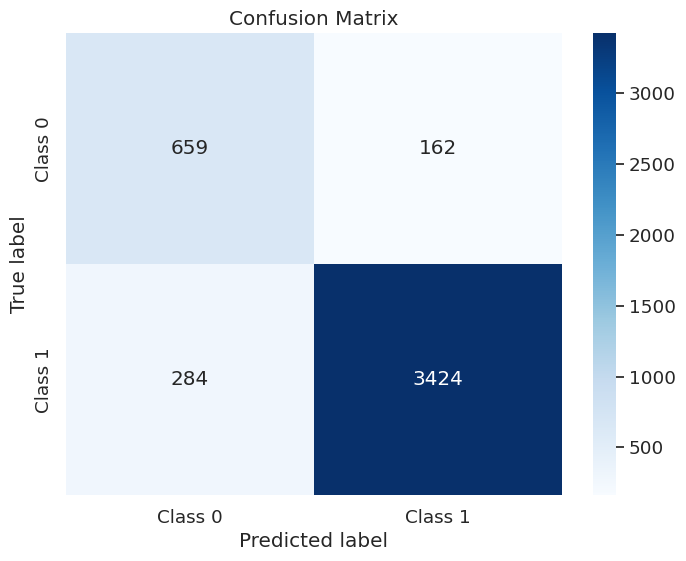

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
task.close()

Далее можно дообучить модель на валидационном датасете, чтобы улучшить метрики. В целом, если смотреть на отдельные семплы, то можно увидеть, что люди просто жалуются на вещь, которая им не подошла, но они ее рекомендуют. Данные модели обученные на датасете sst2, который оринтируется на настроение. Скорей всего, получается так, что грустый отзыв с положительной рекомендацией оценивается моделью не очень. Также навешивание веса на классы, дает перекос в сторону *precision* или *recall*  
https://app.clear.ml/projects/a0e39586066d49ac87ba40b5f2c1ec16/experiments/4b2c1210fcbd42549ca5f905d71bb301/output/execution  
https://app.clear.ml/projects/a0e39586066d49ac87ba40b5f2c1ec16/experiments/6489d05f52ef48b3a81c73f56525a8bf/output/execution

# Дополнительная часть

In [ ]:
test = InitClearml("FinTech VTB", "Distilbert_multiclass (5 classes)")
Task = test.init_task()
task = test.init_experiment(Task)
clearml_available = clearml_logging.clearml_available

Password protected Jupyter Notebook server was found! Add `sdk.development.jupyter_server_password=<jupyter_password>` to ~/clearml.conf


ClearML Task: created new task id=5a3693e3329c4bffab7aa0c540e1722c
ClearML results page: https://app.clear.ml/projects/a0e39586066d49ac87ba40b5f2c1ec16/experiments/5a3693e3329c4bffab7aa0c540e1722c/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


## Распределение оценок

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


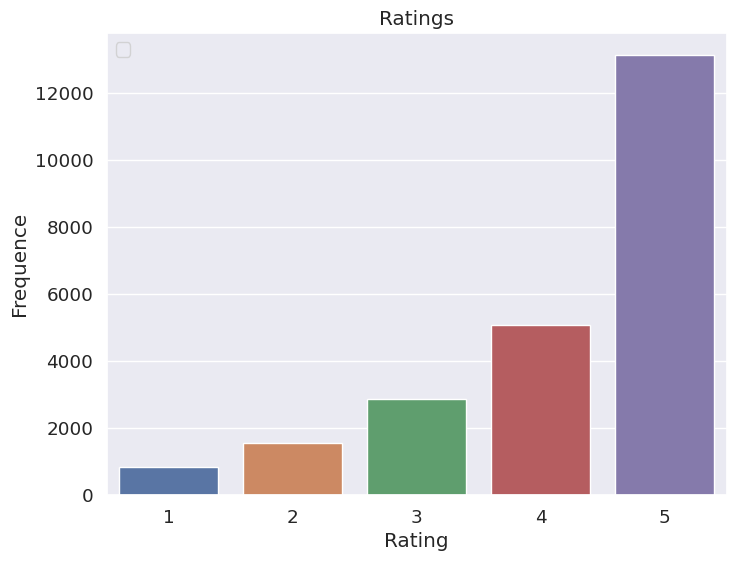

In [ ]:
ratings = df_reviews["Rating"].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=ratings.keys(), y=ratings.values)
plt.title("Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequence")
plt.show()

## Препроцессинг текста

In [ ]:
df_reviews_multi_classification = df_reviews[["Review Text", "Rating"]]

In [ ]:
df_cleared_multi_class = df_reviews_multi_classification.copy()
df_cleared_multi_class["Review Text"] = df_cleared_multi_class["Review Text"].apply(
    lambda x: preprocess_text(x, method="spacy", clean_stopwords=False)
)

In [ ]:
df_cleared_multi_class.head()

,Review Text,Rating
0,absolutely wonderful silky and sexy and comf...,4
1,love this dress it be sooo pretty I happen...,5
2,I have such high hope for this dress and reall...,3
3,I love love love this jumpsuit it be fun flirt...,5
4,this shirt be very flattering to all due to th...,5


In [ ]:
df_cleared_multi_class.to_csv("df_cleared_multi_class.csv", index=False)

## Инициализация модели для мультиклассовой классификации

In [ ]:
task_params = {}
model_params = {}

model_name = "distilbert/distilbert-base-uncased"
model_params["model_name"] = model_name

tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model_params["tokenizer"] = str(tokenizer.__class__)

num_labels = 5
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model_params["model"] = str(model.__class__)
model_params["num_class"] = num_labels

task_params["model"] = model_params

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Очищенный датасет

In [ ]:
full_dataset = load_dataset("csv", data_files="df_cleared_multi_class.csv")
full_dataset = full_dataset.rename_columns(
    column_mapping={"Rating": "labels", "Review Text": "text"}
)
# Фильтрация записей, в которых текстовые поля или метки не являются None
full_dataset = full_dataset.filter(
    lambda example: example["text"] is not None and example["labels"] is not None
)

full_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/23486 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 22641
    })
})

## Train/Validate/Test и токенизация

In [ ]:
train_valid_test = (
    full_dataset["train"]
    .class_encode_column("labels")
    .train_test_split(test_size=0.2, stratify_by_column="labels", seed=1)
)
valid_test = train_valid_test["test"].train_test_split(
    test_size=0.5, stratify_by_column="labels", seed=1
)

dataset = DatasetDict(
    {
        "train": train_valid_test["train"],
        "validate": valid_test["train"],
        "test": valid_test["test"],
    }
)
dataset

Stringifying the column:   0%|          | 0/22641 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/22641 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 18112
    })
    validate: Dataset({
        features: ['text', 'labels'],
        num_rows: 2264
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2265
    })
})

Map:   0%|          | 0/18112 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/2265 [00:00<?, ? examples/s]

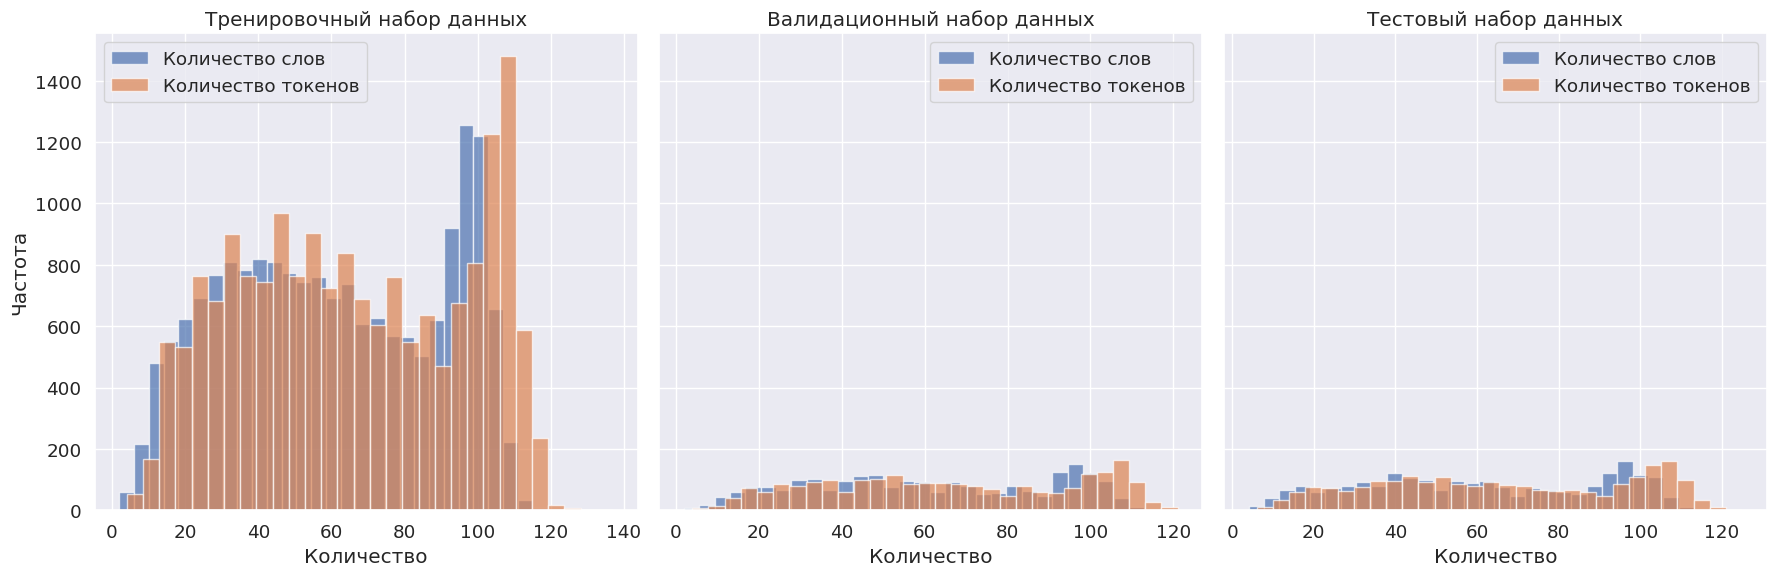

In [ ]:
dataset_info = dataset.map(
    lambda e: tokenizer(e["text"], truncation=True), batched=True
)

train_word_counts = [len(example["text"].split()) for example in dataset["train"]]
train_token_counts = [len(example) for example in dataset_info["train"]["input_ids"]]

valid_word_counts = [len(example["text"].split()) for example in dataset["validate"]]
valid_token_counts = [len(example) for example in dataset_info["validate"]["input_ids"]]

test_word_counts = [len(example["text"].split()) for example in dataset["test"]]
test_token_counts = [len(example) for example in dataset_info["test"]["input_ids"]]

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].hist(train_word_counts, bins=30, alpha=0.7, label="Количество слов")
axes[0].hist(train_token_counts, bins=30, alpha=0.7, label="Количество токенов")
axes[0].set_title("Тренировочный набор данных")
axes[0].set_xlabel("Количество")
axes[0].set_ylabel("Частота")
axes[0].legend()

axes[1].hist(valid_word_counts, bins=30, alpha=0.7, label="Количество слов")
axes[1].hist(valid_token_counts, bins=30, alpha=0.7, label="Количество токенов")
axes[1].set_title("Валидационный набор данных")
axes[1].set_xlabel("Количество")
axes[1].legend()

axes[2].hist(test_word_counts, bins=30, alpha=0.7, label="Количество слов")
axes[2].hist(test_token_counts, bins=30, alpha=0.7, label="Количество токенов")
axes[2].set_title("Тестовый набор данных")
axes[2].set_xlabel("Количество")
axes[2].legend()


plt.tight_layout()
plt.show()

In [ ]:
params_tokenizer = {}
params_tokenizer["max_length_seq_words"] = 130

dataset = dataset.map(
    lambda e: tokenizer(
        e["text"],
        truncation=True,
        max_length=params_tokenizer["max_length_seq_words"],
        padding="max_length",
    ),
    batched=True,
)

task_params["tokenizer"] = params_tokenizer

Map:   0%|          | 0/18112 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/2265 [00:00<?, ? examples/s]

## Dataloader

In [ ]:
params_datasets = {}
params_datasets["batch_size_train"] = 32
params_datasets["batch_size_validate"] = 16
params_datasets["batch_size_test"] = 16

dataset_delete_text = dataset.remove_columns("text")

dataset_delete_text.set_format(type="torch", device=device)
train_dataloader = DataLoader(
    dataset_delete_text["train"],
    shuffle=True,
    batch_size=params_datasets["batch_size_train"],
)
validate_dataloader = DataLoader(
    dataset_delete_text["validate"],
    shuffle=True,
    batch_size=params_datasets["batch_size_validate"],
)
test_dataloader = DataLoader(
    dataset_delete_text["test"],
    shuffle=False,
    batch_size=params_datasets["batch_size_test"],
)

task_params["params_dataset"] = params_datasets

## Trainer

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
weights_multiclass = compute_class_weight(class_weight="balanced", classes=sorted(list(set(full_dataset["train"]["labels"]))), y=full_dataset["train"]["labels"]).tolist()
weights_multiclass

[5.515468940316687,
 2.9233053582956745,
 1.60403825717322,
 0.9226161369193154,
 0.36110047846889953]

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")

        outputs = model(**inputs)
        logits = outputs.get('logits')

        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([3.5, 1.9, 1.4, 1.2, 0.9]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1).to(device))
        return (loss, outputs) if return_outputs else loss

In [ ]:
f1_metric = load_metric("f1", trust_remote_code=True)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=600,
    weight_decay=0.01,
    logging_dir="./runs",
    logging_steps=200,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return f1_metric.compute(predictions=predictions, references=labels, average="macro")

trainer = CustomTrainer(
    model=model,  # Модель для обучения
    args=training_args,  # Аргументы обучения
    train_dataset=dataset["train"],  # Набор данных для обучения
    eval_dataset=dataset["validate"],  # Набор данных для валидации
    compute_metrics=compute_metrics,  # Метрики для вычисления
)

In [ ]:
trainer.train()

Parameters must be of builtin type (Transformers_7/accelerator_config[AcceleratorConfig])


Epoch,Training Loss,Validation Loss,F1
1,0.483400,1.229787,0.513255
2,0.402500,1.268178,0.512706
3,0.231000,1.505778,0.496708


TrainOutput(global_step=1698, training_loss=0.39918002363368954, metrics={'train_runtime': 637.239, 'train_samples_per_second': 85.268, 'train_steps_per_second': 2.665, 'total_flos': 1827651124166400.0, 'train_loss': 0.39918002363368954, 'epoch': 3.0})

In [ ]:
task.close()

С весами получается хуже, чем без них. Мб можно было попробовать аугментацию, но на занятии такого мы не делали.  
https://app.clear.ml/projects/a0e39586066d49ac87ba40b5f2c1ec16/experiments/5a3693e3329c4bffab7aa0c540e1722c/output/execution (без весов на  классы f1=0.53 )